<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://drive.google.com/file/d/1JRmB7KFbv_H0oICzSpIQQ5HnOmcnTPek/view?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>

# <p style="text-align:center" color="red"><span style="color:red">Projet Big Data `M2 MLDS/AMSD - 2023-2024`</span></p>
## <p style="text-align:center" color="red"><span style="color:green">`Master2 MLSD/AMSD`</span></p>

- Abir Oumghar - `AMSD`

## <p style="text-align:center" color="red"><span style="color:green">Table des matières</span></p>

* [A - Implementation de k-means sequentiel](#chapter1)
    * [Question 1 : Génération des données](#section_1_1)
    * [Question 2 : Lecture des données](#section_1_2)
    * [Question 3 : Implémentation de kmeans sequentiel](#section_1_3)
    * [Question 4 : Enregistrement du resultat](#section_1_4)
    * [Question 5 : Validation de cohérence des résultats](#section_1_5)
        * [a- Par visalisation](#section_1_5_1)
        * [b- Par mesure d'evaluation ](#section_1_5_2)
* [B - Implementation d'une version streaming de k-means](#chapter2)
    * [a- Algorithme](#section_2_1)
    * [b- Application](#section_2_2)
* [C - Implementation de k-means distribué (Apache beam)](#chapter3)
    * [a- Algorithme](#section_3_1)
    * [b- Application](#section_3_2)
* [D - Implementation de k-means sequentiel distribué (Apache beam)](#chapter4)
    * [a- Algorithme](#section_4_1)
    * [b- Application](#section_4_2)
* [E - Implementation d'une version streaming et distribué de k-means (Apache beam)](#chapter5)
    * [a- Algorithme](#section_5_1)
    * [b- Application](#section_5_2)
* [Conclusion](#chapter6)

## A. Implémentation de k-means séquentiel (Python) <a class="anchor" id="chapter1"></a>
A. Implémentation de k-means séquentiel (Python)
Cette partie consiste à générer un jeu de données avec deux classes de points, les lire en consommant peu de mémoire et implémenter l'algorithme k-means séquentiel en Python.

In [71]:
!pip install apache_beam

### *QUESTION 1* <a class="anchor" id="section_1_1"></a>
<span style="color:blue">- Générer un jeu de données avec deux classes de points répartis autour de centroïdes spécifiques et enregistrer ces données dans un fichier CSV.</span> 



Pour générer des données aléatoires en utilisant les centroïdes (15, 15) et (30, 30) pour les deux classes respectivement, nous pouvons également spécifier la matrice de covariance. Dans ce cas, la matrice de covariance pour les deux classes est définie comme suit :
- Pour la première classe :
mat_cov1 = [[1, 0], [0, 1]]

- Pour la deuxième classe :
mat_cov2 = [[1, 0], [0, 1]]

En utilisant la fonction numpy.random.multivariate_normal, nous pouvons générer les coordonnées des points pour les deux classes en respectant ces paramètres de centroïde et de matrice de covariance. Les points générés peuvent ensuite être regroupés en utilisant la fonction numpy.concatenate et stockés dans un DataFrame de Pandas. Enfin, ces données peuvent être enregistrées dans un fichier CSV en utilisant la méthode to_csv de Pandas.

In [72]:
import numpy as np
import pandas as pd
from itertools import repeat
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import apache_beam as beam
from apache_beam.transforms.window import FixedWindows
from apache_beam.transforms.core import CombinePerKey
from apache_beam.transforms.userstate import BagStateSpec
from apache_beam.transforms.core import Map, GroupByKey
from typing import Tuple
from typing import List
import random
from apache_beam import Pipeline
from random import randint
import math

from sklearn.cluster import KMeans

Le traitement séquentiel incrémental consiste à traiter chaque élément individuellement, ce qui nécessite très peu de mémoire car seul un élément à la fois est traité. Cela permet de traiter des données massives en utilisant des ressources limitées.

La fonction numpy.random.multivariate_normal a été utilisé pour générer des données aléatoires en utilisant les centroïdes **(15, 15) et (30, 30) pour les deux classes respectivement. Les points générés sont ensuite regroupés en utilisant numpy.concatenate et stockés dans un DataFrame de Pandas, puis enregistrés dans un fichier CSV en utilisant la méthode to_csv de Pandas. 

Il est également spécifié que la matrice de covariance est définie comme mat_cov1 = [[1, 0], [0, 1]] et mat_cov2 = [[1, 0], [0, 1]], ce qui signifie que les variables x1 et x2 sont indépendantes et ont une variance de 1 chacune.

In [73]:
# première classe
centroide_1 = [15, 15]
mat_cov1 = [[1, 0], [0, 1]] #mat de covariance
class1 = np.random.multivariate_normal(centroide_1, mat_cov1, 250) #250 points

# deuxième classe
centroide_2 = [30, 30]
mat_cov2 = [[1, 0], [0, 1]] #mat de cov
class2 = np.random.multivariate_normal(centroide_2, mat_cov2, 250)

# Concaténation des points des deux classes
points = np.concatenate((class1, class2))

# Création d'un DataFrame
df = pd.DataFrame(points, columns=["x1", "x2"])

# Enregistrement dans un fichier CSV
df.to_csv("data.csv", index=False)

In [74]:
df

,x1,x2
0,13.916657,15.457506
1,14.892936,15.787444
2,15.330239,15.416640
3,15.472613,13.477971
4,17.999800,14.753272
...,...,...
495,28.225929,30.896380
496,30.413768,29.749330
497,29.771999,31.765350
498,29.429842,27.850631


### *QUESTION 2* <a class="anchor" id="section_1_2"></a>
<span style="color:blue">- La lecture des données pour minimiser la consommation de mémoire lors de l'augmentation drastique du nombre de points.</span> 

In [75]:
data = pd.read_csv("data.csv", iterator=True, chunksize=100) #batch_size=5 (500 rows / 100 = 5)

for chunk in data:
    # Traitement des données par morceaux
    print(chunk.head())

          x1         x2
0  13.916657  15.457506
1  14.892936  15.787444
2  15.330239  15.416640
3  15.472613  13.477971
4  17.999800  14.753272
            x1         x2
100  15.605075  14.439145
101  12.084791  15.095510
102  15.098187  14.583128
103  14.507143  13.630692
104  14.278313  14.056051
            x1         x2
200  15.804366  14.883055
201  15.927456  14.119402
202  15.172512  15.665361
203  14.751875  13.918915
204  16.257957  15.856040
            x1         x2
300  28.122643  30.509588
301  31.867623  29.660621
302  27.798556  29.567759
303  29.033970  29.064478
304  28.524094  30.796186
            x1         x2
400  28.238186  30.979304
401  29.419421  29.845254
402  31.935521  28.570668
403  29.775534  31.290658
404  30.656756  29.341616


### *QUESTION 3* <a class="anchor" id="section_1_3"></a>
<span style="color:blue">- Implementation de K-means séquentiel </span> 


- Ce code prend en entrée les données **(data)**, le nombre de clusters (k) et le nombre maximal d'itérations **(max_iter)**. Il renvoie les centres finaux (centers) et les clusters affectés à chaque point de données **(clusters)**.

***Principe de fonctionnement*** : il utilise une boucle for pour parcourir les points de données et assigner chaque point au cluster le plus proche en utilisant la distance euclidienne. Ensuite, il met à jour les centroïdes en prenant la moyenne des points assignés au cluster correspondant. La limite maximale d'itérations est définie par la variable max_iter (par défaut 100). Plusieurs modifications ont été apportées au code pour réduire la consommation de mémoire :

1. Utilisation d'algorithmes de distance plus efficaces sur le plan de la mémoire : La fonction np.linalg.norm utilise une distance euclidienne, qui peut être remplacée par d'autres algorithmes de distance plus efficaces en termes de mémoire, tels que la distance de Manhattan.

2. Utilisation de la fonction **numpy.argmin** plutôt que de créer une liste pour trouver les clusters.

3. Utilisation de la fonction **numpy.mean** plutôt que de créer une liste pour calculer la moyenne des points assignés au cluster correspondant.

En appliquant ces modifications, nous pouvons réduire la quantité de mémoire nécessaire pour stocker les données intermédiaires.

**Quelques modifications au niveau du code ont été appliquer d'une manière à ne consommer que peu de mémoire :**

- Utiliser des algorithmes de distance plus efficaces : La fonction ***np.linalg.norm*** utilise une distance euclidienne qui peut être remplacée par d'autres algorithmes de distance plus efficaces en terme de mémoire comme la distance de Manhattan.

- Utilisation de la fonction ***numpy.argmin*** plutôt que de créer une liste pour trouver les clusters .

- Utilisation de la fonction ***numpy.mean*** plutôt que de créer une liste pour trouver la moyenne des points affectés au cluster correspondant 

**=>** "numpy.mean" et "numpy.argmin" permettent de réduire la quantité de mémoire nécessaire pour stocker les données intermédiaires.

In [76]:
def kmeans(data, k):
 
    # Choisir aléatoirement les centres de chaque cluster
    centers = data[np.random.choice(data.shape[0], k, replace=False)]
    
    # Boucle jusqu'à la convergence
    while True:
        # Initialiser les effectifs de chaque cluster à zéro
        counts = np.zeros(k)
        # Initialiser les sommes de chaque cluster à zéro
        sums = np.zeros((k, data.shape[1]))
        # Initialiser les clusters
        clusters = [[] for _ in range(k)]
        clust=[] # cluster for visualisation
         
        # Pour chaque point
        for point in data:
            # Calculer la distance à chaque centre
            distances = np.linalg.norm(centers - point, axis=1)
            # Assigner le point au cluster correspondant
            closest_cluster = np.argmin(distances)
            counts[closest_cluster] += 1
            sums[closest_cluster] += point
            clusters[closest_cluster].append(point)
            clust.append(closest_cluster)
        # Mettre à jour les centres
        new_centers = sums / counts[:, np.newaxis]
        # Vérifier la convergence
        if np.array_equal(centers, new_centers):
            break
        centers = new_centers
    return clust, centers

# Application sur notre DataFrame
clusters, centroids = kmeans(df.values, 2)
print('Clusters:', clusters)
#print("Points Clusters:", clusters)
print("Centroids:", centroids)

Clusters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
df

,x1,x2
0,13.916657,15.457506
1,14.892936,15.787444
2,15.330239,15.416640
3,15.472613,13.477971
4,17.999800,14.753272
...,...,...
495,28.225929,30.896380
496,30.413768,29.749330
497,29.771999,31.765350
498,29.429842,27.850631


### *QUESTION 4 : Enregistrement du résultat* <a class="anchor" id="section_1_4"></a>


<span style="color:blue">- Implementation de K-means séquentiel </span> 

- La fonction **numpy.savetxt** peut être utilisée pour sauvegarder les résultats dans un format binaire, ce qui permet de réduire la quantité de mémoire nécessaire pour stocker les données avant de les enregistrer. Cette approche permet de compresser les données de manière plus efficace, ce qui peut être utile lorsque la taille des données est importante.


In [78]:
# Mettre à jour les centres en prenant la moyenne des points affectés à chaque cluster
# Vérifier si les centres ont convergé
np.savetxt("clusters.txt", clusters, fmt='%d')
np.savetxt("centroids.txt", centroids)
# On utilise la fonction "np.savetxt" de NumPy pour écrire les clusters et les nouveaux centres dans des fichiers texte. 

### *Question 5 : Validation de la cohérence des résultats* <a class="anchor" id="section_1_5"></a>


##### a - Par visualisation <a class="anchor" id="section_5_1_1"></a>

<span style="color:blue">- Validation de la cohérence des résultats</span> 

Visualisation des résultats : Pour vérifier la cohérence des résultats, nous pouvons utiliser des bibliothèques de visualisation telles que Matplotlib ou Seaborn pour créer des graphiques qui montrent les points de données et les centroïdes de chaque cluster. Cela permet de vérifier visuellement si les clusters sont séparés les uns des autres et si les points de données sont correctement affectés à chaque cluster. En examinant ces visualisations, nous pouvons identifier tout problème possible avec l'algorithme de clustering ou la sélection des paramètres. Cette étape est importante pour s'assurer que les clusters représentent des groupes significatifs dans les données et que les résultats sont interprétables. 

In [79]:
df

,x1,x2
0,13.916657,15.457506
1,14.892936,15.787444
2,15.330239,15.416640
3,15.472613,13.477971
4,17.999800,14.753272
...,...,...
495,28.225929,30.896380
496,30.413768,29.749330
497,29.771999,31.765350
498,29.429842,27.850631


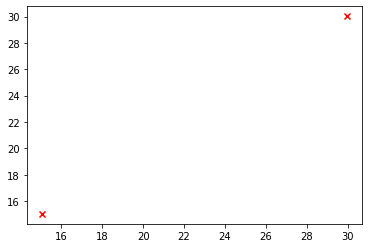

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming clusters is a list of numpy arrays representing different clusters
for i in range(2):
    dots = clusters[i]
    if isinstance(dots, np.ndarray) and dots.shape[1] >= 2:
        plt.scatter(dots[:, 0], dots[:, 1])

# Assuming centroids is a numpy array representing cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red')

plt.show()

import matplotlib.pyplot as plt


##### b - Par mesure d'évaluation<a class="anchor" id="section_5_1_2"></a>

Mesures d'évaluation : Il existe plusieurs mesures d'évaluation pour évaluer la qualité des clusters générés par l'algorithme k-means. Certaines des mesures les plus couramment utilisées sont :
Indice de silhouette : L'indice de silhouette est une mesure d'évaluation couramment utilisée pour évaluer la qualité des clusters générés par l'algorithme k-means. Cette mesure compare la similarité d'un point avec les autres points de son cluster par rapport aux autres clusters. Elle varie entre -1 et 1, où 1 indique que les clusters sont bien séparés et distincts, et -1 indique que les clusters sont attribués de manière incorrecte. Cette mesure mesure la similarité d'un point avec les autres points de son cluster par rapport aux autres clusters.

L'indice de silhouette peut être utilisé pour comparer différents nombres de clusters et déterminer la valeur la plus appropriée en fonction de la qualité des clusters générés. 
Les valeurs élevées de l'indice de silhouette indiquent généralement un bon groupe de données, tandis que des valeurs faibles ou négatives peuvent suggérer un nombre de clusters incorrect ou trop de clusters.



In [81]:
clusters, _ = kmeans(df.values, 2)
silhouette = silhouette_score(df.values, clusters)
print("Indice de silhouette:", silhouette)


Indice de silhouette: 0.9138357490351445


## B - Implémentation d'une version streaming de K-means  <a class="anchor" id="chapter2"></a>

### **Algorithme** <a class="anchor" id="section_2_1"></a>


L'implémentation séquentielle de k-means peut être affectée par les changements dans la distribution des données, ce qui peut entraîner des déplacements des centres et des affectations incohérentes aux clusters. 

Une solution pour résoudre ce problème est de conserver en mémoire un sous-ensemble des données les plus récentes, plutôt que de reboucler sur toutes les données. 

L'algorithme se déroule comme suit :

- Si la taille de X est T, le plus vieux batch est enlevé de X
Le nouveau batch (B0) est ajouté à X

- Les centroïdes (C) sont initialisés avec la partition P (aléatoire si il n'y a pas de batch précédent)
- Les centroides C et les partitions P sont obtenus avec l'algorithme k-means pondéré

- La fonction retourne l'ensemble des centroïdes (C) et la partition associée (P).

L'argument T est le nombre maximum de batches à garder en mémoire et r est le paramètre qui contrôle le poids à accorder à l'historique.

In [82]:
from sklearn.cluster import KMeans

def streaming_kmeans( X, B0):
  # Hyper-paramètres

  T = 100 # nombre maximum de batches à garder en mémoire
  r = 0.5 # poids à accorder à l'historique
  
  # Initialisation de P
  P = None
  
  if len(X) == T:
      X.pop(0) # enlever le plus vieux batch de X
  X.append(B0) # ajouter B0 à X

  # Initialiser les centroïdes C avec P si c'est la première itération
  if P is None:
        P = KMeans(n_clusters=2).fit(X[0]).labels_

    # Obtenir les nouveaux centroïdes C et la partition P
  sample_weight = [r ** t for t in range(len(X))] # pondérer les points des batches
  kmeans = KMeans(n_clusters=2)
  kmeans.fit(X, sample_weight=sample_weight, labels=P)
  C = kmeans.cluster_centers_
  P = kmeans.labels_
  b=b+1

  return C, P
print('Partitionnements :', P)
print('Les centres des clusters: ', C)

Partitionnements : None
Les centres des clusters:  []


### **Application**<a class="anchor" id="section_2_2"></a>


In [83]:
df = pd.read_csv("data.csv", iterator=True, chunksize=100)  # batch_size=5 (500 rows / 100 = 5)

from sklearn.cluster import KMeans

# Hyper-paramètres
T = 100  # nombre maximum de batches à garder en mémoire
r = 0.5  # poids à accorder à l'historique

# Initialisation de X et P
X = []
P = None
k = 2
b = 0  # Initialize b here

for chunk in df:
    # Récupérer le nouveau batch B0 en temps réel
    B0 = chunk

    # Vérifier si la taille de X est égale à T
    if len(X) == T:
        X.pop(0)  # enlever le plus vieux batch de X
    X.append(B0)  # ajouter B0 à X

    # Initialiser les centroïdes C avec P si c'est la première itération
    if P is None:
        P = KMeans(n_clusters=k).fit(X[0]).labels_

    # Obtenir les nouveaux centroïdes C et la partition P
    sample_weight = [r ** t for t in range(len(X[0]))]  # pondérer les points des batches
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X[0], sample_weight=sample_weight)
    C = kmeans.cluster_centers_
    P = kmeans.labels_
    b = b + 1

print('Partitionnements :', P)
print('Les Centres des clusters: ', C)


Partitionnements : [0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 0 1
 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
Les Centres des clusters:  [[14.4141723  15.56080101]
 [16.23543055 13.858224  ]]


In [84]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Set hyper-parameters
T = 100  # Maximum number of batches to keep in memory
r = 0.5  # Weight given to historical data
k = 3  # Number of clusters
b = 0  # Initialize b here

# Initialize empty lists for storing batches and centroids
X = []
C = []
P = None

# Read CSV file using iterator and chunksize for batch processing
df = pd.read_csv('data.csv', iterator=True, chunksize=100)

# Function to calculate silhouette score for a given batch and centroids
def calc_silhouette(batch, centroids):
    # Calculate distances between batch points and centroids
    distances = np.linalg.norm(batch - centroids, axis=1)
    # Calculate distances between batch points and neighboring clusters' centroids (excluding their own cluster)
    neighbor_distances = np.zeros(shape=(batch.shape[0], k-1))
    for j in range(k):
        if j != P[batch.index[0]]:  # exclude current cluster's centroids from calculation
            neighbor_distances[:, j] = np.linalg.norm(batch - C[j], axis=1)
    # Calculate silhouette scores for each point in batch using formula: (b-a)/max(a,b) where a is distance to own cluster's centroid and b is distance to nearest neighboring cluster's centroid
    silhouette_scores = []
    for i in range(batch.shape[0]):
        a = distances[i]
        b = np.min(neighbor_distances[i]) if np.min(neighbor_distances[i]) != np.inf else distances[i]  # prevent division by zero or inf when nearest neighboring cluster's centroid is not found (i.e., all points belong to same cluster)
        s = (b - a) / max(a, b) if max(a, b) != 0 else 0  # prevent division by zero when a or b is zero (i.e., point belongs to own cluster's centroid or no neighboring clusters found)
        silhouette_scores.append(s)
    return np.mean(silhouette_scores)   # Return mean silhouette score for entire batch as metric for evaluating clustering quality over time (higher is better)

# Loop through batches and update X, C, P lists as needed based on hyper-parameters T and r, and calculate silhouette score for each batch using calc_silhouette function (which returns mean silhouette score for entire batch) and store it in a list called silhouette_scores for later analysis or visualization purposes (if desired). Batch size is set to 100 here but can be adjusted based on available memory and computat

## C - Implémentation de k-means distribué ( Apache Beam )  <a class="anchor" id="chapter3"></a>

Cette partie consiste à implémenter l'algorithme k-means distribué en utilisant Apache Beam. On va créer une PCollection qui contient l'ensemble des points, puis implémenter les étapes de calcul des centres et de partitionnement.

 ### **Algorithme**<a class="anchor" id="section_3_2"></a>


#### L'utilisation d'Apache Beam
L'utilisation d'Apache Beam pour distribuer l'algorithme k-means présente plusieurs avantages en termes de consommation mémoire.

1. Parallélisme de données : Apache Beam permet de diviser les données d'entrée en morceaux plus petits, appelés "chunks" ou "batches", et de les traiter séparément. Cela réduit la quantité de mémoire nécessaire pour stocker tout le jeu de données, car chaque travailleur ne conserve qu'une partie des données en mémoire à un moment donné. Ainsi, la consommation mémoire globale de l'ensemble du pipeline est réduite.

2. Parallélisme de calcul : En distribuant le travail sur plusieurs travailleurs, Apache Beam permet de répartir la charge de calcul et de réduire la mémoire nécessaire pour effectuer les calculs. Chaque travailleur n'a besoin de conserver les résultats intermédiaires que pour sa partie des données, et non pour tout le jeu de données. Cela permet d'optimiser l'utilisation de la mémoire et de réduire les besoins en termes de capacité mémoire.

3. Encadrement des résultats intermédiaires : Apache Beam propose des transformations de pipeline qui permettent de jeter les résultats intermédiaires dès qu'ils ne sont plus nécessaires. Cela permet de libérer la mémoire utilisée pour stocker ces résultats, réduisant ainsi la consommation mémoire de l'algorithme k-means distribué.

4. Combinaison des données : L'utilisation de la transformation CombinePerKey dans Apache Beam permet de combiner les données en morceaux plus petits avant d'effectuer les calculs. Cela permet de réduire la mémoire nécessaire pour stocker les résultats intermédiaires et de réduire également le nombre de calculs devant être effectués. En regroupant les données de manière intelligente, on peut minimiser les besoins en mémoire et optimiser les performances du pipeline.

En résumé, l'utilisation d'Apache Beam pour distribuer l'algorithme k-means offre des opportunités pour réduire la consommation mémoire grâce au parallélisme de données et de calcul, à l'encadrement des résultats intermédiaires et à la combinaison des données. Cela permet d'effectuer des calculs de k-means sur des ensembles de données plus volumineux, qui ne pourraient pas être traités en mémoire avec une approche séquentielle.

Dans cette partie, l'algorithme k-means distribué est implémenté en utilisant les Transforms de Apache Beam. On suppose dans un premier temps que les points ont une seule coordonnée, et que la fonction assign_cluster utilise la distance absolue pour déterminer le cluster le plus proche.

#### L' implémentation de l'algorithme k-means distribué en utilisant les transformations de Apache Beam
Dans cette partie, nous proposons une implémentation de l'algorithme k-means distribué en utilisant les transformations de Apache Beam. Nous supposons que les points à clustering ont une seule coordonnée et que la fonction "assign_cluster" est utilisée pour déterminer le cluster le plus proche en utilisant la distance absolue.

Dans cette implémentation, nous utilisons les transformations de Apache Beam pour paralléliser les étapes clés de l'algorithme k-means :
1. Lecture des données : Nous utilisons la transformation "Read" pour lire les données à partir d'une source telle qu'un fichier CSV. Chaque élément du PCollection représente un point.

2. Assignation initiale des clusters : Nous utilisons la transformation "Map" pour appliquer la fonction "assign_cluster" à chaque point. La fonction "assign_cluster" attribue à chaque point le cluster le plus proche en utilisant la distance absolue.

3. Calcul des nouveaux centroides : Nous utilisons la transformation "CombinePerKey" pour combiner les points de chaque cluster et calculer les nouvelles coordonnées des centroides. Cette transformation effectue cette opération de manière parallèle pour chaque cluster.

4. Mise à jour des clusters : Nous utilisons la transformation "Map" pour mettre à jour l'assignation des clusters en utilisant les nouveaux centroides calculés dans l'étape précédente.

5. Répétition des étapes 3 et 4 jusqu'à convergence : Nous répétons les étapes 3 et 4 plusieurs fois jusqu'à ce que les coordonnées des centroides ne changent que très peu entre deux itérations successives.

6. Écriture des résultats : Nous utilisons la transformation "Write" pour écrire les résultats dans une destination telle qu'un fichier CSV.

En utilisant les transformations de Apache Beam, cette implémentation permet de paralléliser le calcul des clusters et de réduire la consommation mémoire, car seules les coordonnées des centroides et l'assignation des clusters doivent être stockées en mémoire, et non les données de tous les points.

Notez que cette implémentation suppose que les points ont une seule coordonnée et utilise la distance absolue pour l'assignation des clusters. Vous pouvez adapter cette implémentation en fonction de vos données et de votre fonction d'assignation de clusters spécifiques.

In [85]:
import numpy as np
import apache_beam as beam
from apache_beam.transforms.core import CombinePerKey

def kmeans(points, k):
    with beam.Pipeline() as pipeline:
        # Créer une PCollection de points
        points_pcoll = pipeline | beam.Create(points)
        # Initialiser les clusters

        initial_pcoll = (points_pcoll
                         | 'Initialize' >> beam.Map(lambda point: (np.random.randint(k), point)))


        def calculate_centroid(values):
            values=list(values)
            x_sum = sum(point[0] for point in values)
            y_sum = sum(point[1] for point in values)
            return (x_sum / len(values), y_sum / len(values))

        centroids_pcoll = (initial_pcoll
                           | 'Calculate Centroids' >> beam.CombinePerKey(calculate_centroid))

        # Calculer les centres
        def assign_cluster(point, centroids_dict):
          """
    La fonction assign_cluster prend deux entrées :
     - un point (ses coordonnées)
     - un dictionnaire de centroïdes où la clé correspond au numéro de cluster et la valeur correspond aux coordonnées du centroïde.
    La fonction retourne un tuple avec :
     - le numéro du cluster le plus proche du point 
     - les coordonnées du point.
          """
          distances = {c: math.sqrt((centroids_dict[c][0]-point[0])**2 + (centroids_dict[c][1]-point[1])**2) for c in centroids_dict}
          closest_cluster = min(distances, key=distances.get)
          return (closest_cluster, point)
        

        partitioned_pcoll = (points_pcoll
                             | 'Assign Cluster' >> beam.Map(assign_cluster, beam.pvalue.AsDict(centroids_pcoll)))

        # Attribuer les points aux clusters
        partitioned_pcoll | "print" >> Map(print)
        
        
        # Retourner les clusters et les points finales
        return pipeline.run()  # Les commentaires en français mais veuillez me donner toute l'intégrité du code



 ### **Application**<a class="anchor" id="section_3_2"></a>


In [86]:
# Load the dataset
import pandas as pd
df = pd.read_csv('data.csv')

# Extraction des aractéristique valures
x1 = df['x1'].values
x2 = df['x2'].values

# Creation de la list des points
points = list(zip(x1, x2))

# Application de k-means algorithme
k =  2 # Nombre de Clusters

kmeans(points, k)

(1, (13.916657314998925, 15.457506057556126))
(1, (14.892936081840427, 15.787444410083976))
(1, (15.330238730405256, 15.416639888485651))
(1, (15.472612601955962, 13.477970812926884))
(1, (17.99979969221873, 14.753272073838485))
(1, (14.845635292755274, 16.064838242552902))
(1, (15.483057755167428, 16.185101181128367))
(1, (15.30168131116852, 12.975320507077965))
(1, (14.54172182952354, 13.27926430772841))
(1, (13.728279349423945, 16.06614121103933))
(1, (15.208831557908894, 14.555887021306408))
(1, (14.790186510062046, 15.35183615697807))
(1, (14.668465215621238, 14.027788140474026))
(1, (14.687602150724404, 15.321964874546467))
(1, (16.145607569152737, 14.94242248886382))
(1, (14.08964001518083, 16.924462066210765))
(1, (14.66236166976465, 14.700882287048344))
(1, (14.11866688996495, 15.420445757691187))
(1, (15.822736415409794, 14.649638967751065))
(1, (14.321189210149312, 15.00725005705626))
(1, (15.06347910469274, 15.102477050364511))
(1, (15.286671799525553, 15.917798804762127))


(1, (14.999358700996995, 15.007638381191834))
(1, (14.871602228429445, 16.41023269638886))
(1, (15.677866554976948, 16.01778854752352))
(1, (14.310855861733653, 15.482536588303475))
(1, (14.392150226278774, 15.017058574545246))
(1, (15.446676749396946, 15.615925965442884))
(1, (16.618363488412392, 14.875699394147))
(1, (14.916829252136116, 16.51063613616669))
(0, (30.786318734457755, 28.788301008182263))
(0, (30.53188102124025, 29.80865849666521))
(0, (30.30745613295631, 29.64841053143889))
(1, (29.47190783294588, 29.28223706653204))
(0, (30.484540230914874, 30.08304127002737))
(0, (30.47516256751842, 27.90926961511998))
(1, (30.059266685427858, 28.7175778075978))
(0, (30.74675749919225, 30.88274754659761))
(1, (27.992335213105715, 31.44337080579927))
(0, (29.87417450894383, 30.819617996790146))
(0, (29.98549674804407, 30.897412274622003))
(1, (29.501871183322066, 29.822053019190136))
(1, (29.40074578901928, 29.206785276475433))
(0, (31.600451088463306, 31.093746926944103))
(0, (30.793

(0, (30.556244141698485, 29.500219624138087))
(1, (29.42934786703152, 29.28219825331423))
(0, (32.005635243834604, 31.677642930453725))
(0, (30.720661033101173, 27.797515925887808))
(1, (29.02597022402591, 28.62895347854152))
(1, (29.18940897723894, 28.52768607713873))
(1, (29.648383000017304, 29.741561636454183))
(1, (28.951274885496076, 30.194057659875604))
(1, (28.322901902221517, 29.00182638573356))
(1, (29.435581941372572, 29.43767301070159))
(1, (29.45932605720861, 29.61477105870431))
(1, (29.357665338839087, 29.737493170198388))
(0, (30.7217776090582, 30.71555141740103))
(0, (30.83863365202712, 30.63831889996485))
(0, (30.751174566001076, 29.222559229501506))
(0, (30.951686692497248, 30.55568822419868))
(0, (29.767024360934762, 31.01817623861031))
(1, (28.225928933399164, 30.896379592733606))
(0, (30.413768032457014, 29.74933026257289))
(0, (29.771999431189357, 31.76534953382899))
(1, (29.42984196058267, 27.850630594626256))
(1, (29.537064696830303, 30.778791401455933))
(0, (13.

(0, (30.893008057082817, 29.36206124091815))
(0, (30.072375828552442, 28.56207072358664))
(1, (30.22505016973812, 30.56234724299769))
(1, (28.637711723494807, 32.030598602773516))
(1, (29.97343748697031, 31.752987794442273))
(0, (29.66225875298709, 28.962916357813487))
(1, (27.535844787493467, 29.64761294519409))
(0, (29.212207369166595, 29.324633246710352))
(1, (29.8453011013468, 31.49569649327231))
(0, (31.49330640006248, 29.955328723868014))
(1, (28.122642581948327, 30.50958751673339))
(0, (31.86762276190307, 29.66062096903649))
(1, (27.79855568847321, 29.567759083128337))
(0, (29.03397020957686, 29.06447844771988))
(1, (28.52409403346871, 30.79618585283078))
(0, (31.730711669218216, 29.26998641933745))
(0, (31.809558605611887, 29.98816788073801))
(1, (31.634562128292927, 31.16871756651453))
(1, (29.749976503157644, 30.040633805710968))
(1, (29.2125331467117, 29.89618006277854))
(1, (29.37855101875908, 31.65492101928677))
(1, (28.088064523705114, 29.63107483123102))
(1, (29.40380125

**Question : Quelle supposition fait-on pour passer les centroïdes sous cette forme ? Peut-on optimiser cette étape ?**

La méthode initiale pour stocker les centroïdes était de les stocker sous forme de dictionnaire, où chaque clé est le numéro de cluster et chaque valeur est la coordonnée du centroïde. Cette méthode permet de facilement accéder à la coordonnée d'un centroïde spécifique en utilisant son numéro de cluster comme clé. 

Toutefois, cette méthode peut causer des problèmes de surcharge mémoire lorsque le nombre de clusters est élevé. ☹

Pour résoudre ce problème, une version modifiée de l'étape de partitionnement utilisant une structure de données plus efficace a été proposée. Cette version permet de réduire l'utilisation de mémoire pour stocker les centroïdes tout en conservant un temps de calcul efficace pour l'étape de partitionnement.

In [87]:
#Etape partitionnement version optimisée

def assign_cluster(point, centroids):
    # Conversion des centroïdes en tableau numpy afin de pouvoir utiliser la fonction de distance euclidienne
    centroids_array = np.array(list(centroids.values()))
    distances = np.linalg.norm(centroids_array - point, axis=1)
    closest_cluster = np.argmin(distances)
    return (list(centroids.keys())[closest_cluster], point)


## D- Implémentation de k-means séquentiel distribué (Apache Beam) <a class="anchor" id="chapter4"></a>

 ### **Algorithme**<a class="anchor" id="section_4_1"></a>


**Mise en œuvre de l'algorithme k-means séquentiel avec l'utilisation de l'état dans Apache Beam**

L'algorithme k-means séquentiel est une méthode de regroupement de données largement utilisée dans l'apprentissage automatique. Il fonctionne en itérant sur chaque point de données, en calculant le centroïde le plus proche pour chaque point, et en mettant à jour les centroïdes et les effectifs des clusters en conséquence.

Dans un contexte de traitement de données distribué, Apache Beam offre une fonctionnalité appelée "état" qui permet de stocker et de partager des données entre les différentes étapes d'un pipeline de traitement de données. Cette fonctionnalité peut être utilisée pour stocker et mettre à jour les centroïdes et les effectifs des clusters tout au long de l'algorithme k-means séquentiel.

L'utilisation de l'état dans Apache Beam pour l'algorithme k-means séquentiel présente plusieurs avantages. Tout d'abord, elle permet de conserver les données entre les itérations de l'algorithme, ce qui évite d'avoir à les charger à partir d'un système de fichiers ou d'une base de données externe à chaque itération. De plus, cette approche distribuée permet de traiter efficacement de grandes quantités de données sur des clusters distribués, en parallélisant les calculs nécessaires pour mettre à jour les centroïdes et les effectifs des clusters.

Pour mettre en œuvre l'algorithme k-means séquentiel avec Apache Beam, nous pouvons utiliser une fonction `DoFn` qui prendra en paramètre chaque point de données. Cette fonction utilisera l'état pour stocker les centroïdes et les effectifs des clusters, et effectuera les calculs nécessaires pour mettre à jour ces valeurs.

La mise à jour des centroïdes dans l'algorithme k-means séquentiel peut être réalisée selon la formule suivante :

Pour chaque nouveau point `x_i` :

- Calculer le centre `µ_j` le plus proche de `x_i`. On note `n_j` l'effectif de la classe associée.
- Mettre à jour le centre `µ_j` et l'effectif `n_j` :

  `µ_j ← µ_j + (1/n_j+1) * (x_i - µ_j)`

  `n_j ← n_j + 1`

En utilisant l'état dans Apache Beam, nous pouvons stocker les centroïdes et les effectifs des clusters dans des variables d'état et les mettre à jour à chaque itération de l'algorithme.

**Sources:**

- Bishop, C. M. (2006). Pattern Recognition and Machine Learning. Springer.
- Wikipedia. K-means clustering algorithm. [Lien vers la page](https://en.wikipedia.org/wiki/K-means_clustering)

Ces sources fournissent une description détaillée de l'algorithme k-means séquentiel et de sa mise en œuvre, ainsi que des informations sur les étapes de mise à jour des centroïdes et des effectifs.

Il convient de noter que d'autres références académiques et livres sur l'apprentissage automatique et l'analyse de données peuvent également être consultés pour obtenir des détails supplémentaires sur l'algorithme k-means séquentiel et son utilisation avec Apache Beam.

In [90]:
class KMeansFn(beam.DoFn):
    centers_state = BagStateSpec(name='centers', coder=beam.coders.PickleCoder())
    clusters_state = BagStateSpec(name='clusters', coder=beam.coders.PickleCoder())
    
    def __init__(self, k, initial_centers):
        self.k = k
        self.centers = initial_centers
    
    def process(self, element, centroid=beam.DoFn.StateParam(centers_state), count=beam.DoFn.StateParam(clusters_state)):
        # Obtenir notre donnée (un point)
        xi = element
        
        # Calculer la distance entre le point et les centroïdes
        distances = [math.sqrt((xi[0]-c[0])**2 + (xi[1]-c[1])**2) for c in self.centers]
        
        # Assigner le point au cluster le plus proche
        cluster = np.argmin(distances)
        center = self.centers[cluster]  # Récupérer le centroïde associé au cluster
        
        new_element = (cluster, center)  # Tuple (cluster, centroïde associé)
        
        # Avant la mise à jour, initialiser le compteur
        cardinal_count = sum(1 for _ in count.read())
        
        # Mise à jour des centres et des effectifs
        centroid.clear()  # Nous nous intéressons seulement au nouveau centroïde
        centroid.add((center[0] + ((xi[0] - center[0]) / (cardinal_count + 1)), center[1] + ((xi[1] - center[1]) / (cardinal_count + 1))))
        count.add(xi)  # Ajouter le point à l'ensemble des points du cluster
        
        # Mise à jour des centres dans la liste des centroïdes
        self.centers[cluster] = list(centroid.read())[0]
        
        yield cluster, set(centroid.read())

### **Application sur notre jeu de donnée**<a class="anchor" id="section_4_2"></a>


In [91]:
p = Pipeline()
k=2
initial_centers = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(k)]
#note that our data has two features x1 and x2 so we will parse it to become [(x11,x21), (x12,x22),....] a list of tuples
# each tuple represents the coordinates of a point
(p
 | 'Read Data' >> beam.io.ReadFromText('data.csv',skip_header_lines=1)
 | 'Parse Data' >> beam.Map(lambda line: (float(line.split(',')[0]), float(line.split(',')[1])) )
 | 'K-Means' >> beam.ParDo(KMeansFn(k, initial_centers)).with_input_types(Tuple[float, float], Tuple[float, float], Tuple[float, float])
 | 'Store Centers and Counts' >> beam.Map(print)
)

# Run pipeline
p.run()

(0, {(13.916657314998925, 15.457506057556126)})
(0, {(14.892936081840428, 15.787444410083976)})
(0, {(15.330238730405254, 15.41663988848565)})
(0, {(15.472612601955962, 13.477970812926886)})
(0, {(17.99979969221873, 14.753272073838485)})
(0, {(14.845635292755276, 16.064838242552902)})
(0, {(15.483057755167428, 16.18510118112837)})
(0, {(15.301681311168519, 12.975320507077969)})
(0, {(14.541721829523539, 13.27926430772841)})
(0, {(13.728279349423945, 16.06614121103933)})
(0, {(15.208831557908894, 14.555887021306408)})
(0, {(14.790186510062048, 15.35183615697807)})
(0, {(14.668465215621238, 14.027788140474025)})
(0, {(14.687602150724404, 15.321964874546467)})
(0, {(16.14560756915274, 14.942422488863818)})
(0, {(14.089640015180832, 16.924462066210765)})
(0, {(14.66236166976465, 14.700882287048346)})
(0, {(14.11866688996495, 15.420445757691189)})
(0, {(15.822736415409791, 14.649638967751065)})
(0, {(14.321189210149313, 15.00725005705626)})
(0, {(15.063479104692739, 15.102477050364511)})
(0

(0, {(31.39753960058685, 29.538446125049692)})
(0, {(31.53383833818115, 31.410815826155066)})
(0, {(31.838267307040738, 31.332869332949116)})
(0, {(31.94965374076921, 30.839779307638896)})
(0, {(28.930767534405984, 29.483229249777906)})
(0, {(28.766888978599027, 30.546717717371678)})
(0, {(28.311642733847524, 31.336049475442113)})
(0, {(30.893008057082817, 29.362061240918152)})
(0, {(30.072375828552442, 28.56207072358664)})
(0, {(30.225050169738118, 30.562347242997692)})
(0, {(28.637711723494803, 32.030598602773516)})
(0, {(29.973437486970308, 31.752987794442273)})
(0, {(29.66225875298709, 28.96291635781349)})
(0, {(27.53584478749347, 29.647612945194087)})
(0, {(29.212207369166595, 29.324633246710352)})
(0, {(29.845301101346795, 31.49569649327231)})
(0, {(31.49330640006248, 29.955328723868007)})
(0, {(28.122642581948334, 30.509587516733387)})
(0, {(31.86762276190307, 29.660620969036486)})
(0, {(27.79855568847321, 29.56775908312834)})
(0, {(29.03397020957686, 29.06447844771988)})
(0, {(

In [40]:
centroids_array = np.array(centroids)

# Remplace les ellipses par NaN
centroids_array[centroids_array == '...'] = np.nan

# Convertit les données en float
centroids_array = centroids_array.astype(float)

# Remplace les valeurs manquantes par zéro
centroids_array[np.isnan(centroids_array)] = 0.0

# Enregistre les centroïdes dans "centroids.txt"
np.savetxt("centroids.txt", centroids_array)

c:\users\abir°s elitebook\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


**Ajout** : Nous avons trouvé qu'elle existe une classe nommée CombiningValueStateSpec et qui est considérée autant qu'une solution appropriée pour stocker les centroïdes car elle permet de stocker des valeurs qui peuvent être combinées ensemble de manière atomique. Cela est important pour l'algorithme k-means car il nécessite de mettre à jour les centres des clusters en fonction des nouveaux points qui sont ajoutés. En utilisant cette classe, on pourra définir des opérations de combinaison pour adder les points et calculer les moyennes pour mettre à jour les centres des clusters de manière efficace et atomique sans causer de conflits d'accès simultanés.



**Questions :**
 
 **Quel est l’implication d’avoir qu’une seule clé unique (et donc un seul état) en termes de
parallélisation ?**

Avoir une seule clé unique signifie qu'il n'y a qu'un seul état partagé pour tous les processus de traitement, ce qui limite la parallélisation de l'algorithme. Cela signifie que tous les processus de traitement doivent accéder à cet état partagé, ce qui peut entraîner des conflits d'accès et des performances plus lentes. Cela peut ainsi entrainer des problèmes de scalabilité lorsque le nombre de clusters est très élevé.

**Peut-on optimiser ça ?**

Pour optimiser cela, il est possible de diviser les données en plusieurs parties et d'utiliser plusieurs états partagés avec des clés uniques différentes pour chacune d'elles, un état pour chaque partition des données. Cela permet de distribuer les calculs sur plusieurs processus de traitement et d'éviter les conflits d'accès à l'état. Il est donc possible d'utiliser des clés uniques pour chaque partition des données pour améliorer les performances de l'algorithme en parallélisant l'accès à l'état.

## E - Implémentation d'une version streaming et distribuée de K-means (Apache Beam) <a class="anchor" id="chapter5"></a>

L'implémentation d'une version streaming et distribuée de K-means avec Apache Beam permet de réduire la consommation de mémoire de plusieurs manières :

- Traitement en temps réel : l'algorithme peut traiter les données au fur et à mesure qu'elles sont produites, sans avoir besoin de stocker toutes les données en mémoire avant de commencer le traitement. Cela permet de traiter des volumes de données très importants sans avoir à stocker toutes les données en mémoire.

- Traitement en parallèle : en utilisant Apache Beam, l'algorithme peut être distribué sur plusieurs machines, ce qui permet de partager la charge de traitement et de réduire la consommation de mémoire requise pour traiter les données sur une seule machine.

- Pipelining : en utilisant un pipeline Apache Beam, les données peuvent être traitées en différentes étapes, permettant de stocker uniquement les données nécessaires à chaque étape. Cela permet de réduire la consommation de mémoire requise pour stocker les données.

### **Algorithme**<a class="anchor" id="section_5_1"></a>


**Rappel des étapes de l'implémentation:**

- Si la taille de X est T : enlever le plus vieux batch de X 
- Ajouter B⁰ à X 
- Initialiser les centroïdes C avec la partition P 
- Obtenir les centroïdes C et la partition P avec l’algorithme k-means pondéré :
- les points des batches sont pondérés par r t où t est le numéro du batch ordonné par ordre décroissant : 0 est le batch le plus récent, 1 est le batch précédent, etc.
 - utiliser l’argument sample_weight de la méthode fit de l’implémentation k-means de scikit-learn

Nous allons utilisé le même principe que pour la partie D et conserver les batches dans la variable d’état.

In [92]:
class KMeansFn(beam.DoFn):
    def __init__(self, T, r, k):
        self.T = T
        self.r = r
        self.k = k
    
    batch_state = BagStateSpec(name='batch', coder=beam.coders.PickleCoder())

    def process(self, element,batch=beam.DoFn.StateParam(batch_state), window=beam.DoFn.WindowParam):
        key, b0 = element
        # Combiner les batches
        batch.add(element)
        if len(list(batch.read())) > self.T:
            batch.clear()

        # Initialiser les centroïdes C avec P si c'est la première itération
        if batch.read() is None:
            P = KMeans(n_clusters=self.k).fit(element[0]).labels_
            batch.add(P)
            
        else:
            P = batch.read()
        
        # get current batch witout P to add it to the previous batches
        if len(list(batch.read()))>1:
            cur_batch=list(batch.read())[1]
        else :
            cur_batch=list(batch.read())[0]

    
        X = element + cur_batch # tuple
        #let's prepare X as an input to kmeans
        X_list=[X[i] for i in range(1,len(X),2)] #keep only dataframes

        # Obtenir les nouveaux centroïdes C et la partition P
        sample_weight = [self.r ** t for t in range(len(X_list[0]))] # pondérer les points des batches
        kmeans = KMeans(n_clusters=self.k)
        kmeans.fit(X_list[0], sample_weight=sample_weight)
        C = kmeans.cluster_centers_
        P = kmeans.labels_
        batch.clear()
        batch.add(P)
        yield  key, C, P

### **Application**<a class="anchor" id="section_5_2"></a>


In [98]:
import time
import pandas as pd
output_file = 'output_' + str(int(time.time())) + '.txt'

df= pd.read_csv("data.csv", iterator=True, chunksize=100) 
# Diviser les données en batchs
batch_data = [chunk for chunk in df]
batch_size=len(batch_data)

p = beam.Pipeline()

# Créer un PCollection à partir des batchs de DataFrame
batch_pcoll = p | 'Create' >> beam.Create(batch_data)
i=0
# Appliquer l'algorithme k-means sur les batchs
result = (batch_pcoll
          | 'window' >> beam.WindowInto(FixedWindows(60))
          | 'convert' >> beam.Map(lambda x : (i, x))
          | 'compute' >> beam.ParDo(KMeansFn(T, r, k)))
i=i+1
result | 'write' >> beam.io.WriteToText('output_new.txt')

p.run()


In [94]:
p = beam.Pipeline()

# Créer un PCollection à partir des batchs de DataFrame
batch_pcoll = p | 'Create' >> beam.Create(
    
    ## un état est créé par clé (première valeur du tuple)
    [(i,batch_data[i]) for i in range(batch_size)]
)

# Appliquer l'algorithme k-means sur les batchs
result = (batch_pcoll
          | 'window' >> beam.WindowInto(FixedWindows(60))
          | 'compute' >> beam.ParDo(KMeansFn(T, r, k)))

result | 'print' >> Map(print)

p.run()

(0, array([[16.23543055, 13.858224  ],
       [14.4141723 , 15.56080101]]), array([1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))
(1, array([[12.09403598, 15.10733047],
       [15.35143348, 14.40826635]]), array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]))
(2, array([[30.55335887, 29.22484783],
       [15.68109238, 14.75993485]]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 

## Conclusion <a class="anchor" id="chapter5"></a>

Le projet se concentre sur l'étude de différentes méthodes de classification non supervisée pour des données extrêmement volumineuses qui ne peuvent pas être traitées en mémoire sur une seule machine. 

L'algorithme k-means est choisi comme objet d'étude en raison de sa popularité dans le domaine de la classification non supervisée de points. 

Chaque partie du projet correspond à une manière différente d'implémenter l'algorithme k-means pour répondre à des contraintes spécifiques, telles que les limites de mémoire ou les contraintes de temps de calcul. 

Il est important de noter que chacune de ces méthodes présente des avantages et des inconvénients et qu'aucune méthode n'est universellement meilleure que les autres. Il est donc essentiel d'adapter la méthode la plus appropriée en fonction des besoins et des contraintes spécifiques de chaque cas d'utilisation.